# Outline
We introduce in this notebook the idea of simulating the acquisition of samples using gVirtualXRay as a step-by-step process. Understanding this experiment will help provide clarity for the validation attempts that follow, including the requisite image correction and process behind validating linear attenuations with the help of masks.

# Results
Comparing linear attenuations of a cyclinder inside a cube obtained from this simulation and those presented in literature evaluated to: a relative error in the simulated cylinder equal to 0.33% and 0.13% in the simulated cube.

In [1]:
%matplotlib inline 

import os
import math # For pi

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import copy
from skimage.transform import iradon
from skimage.draw import disk
from math import floor
import k3d, base64

import imageio
from tifffile import imsave # Write TIFF files

import gvxrPython3 as gvxr
import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-12-06T23:05:25) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-06T23:05:24) [Compiler: Microsoft Visual Studio] on Windows


## Define constants for this experiment

In [2]:
number_of_projections = 1900;
angular_step = 180 / number_of_projections;

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [3]:
json2gvxr.initGVXR("notebook-9.json", "OPENGL")

Create an OpenGL context: 512x512


## X-ray source

We create an X-ray source. It is a parallel source.

In [4]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


## Spectrum

The spectrum is monochromatic.

In [5]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)

## Detector

Create a digital detector

In [6]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [128, 128]
	Pixel spacing: [0.5859375, 0.5859375, 'cm']


## Scanned object

We create a cylinder. Its linear attenuation coefficient is 0.5 cm<sup>-1</sup>. The cylinder is within  a cube whose linear attenuation coefficient is 0.1 cm<sup>-1</sup>.

In [7]:
json2gvxr.initSamples("notebook-9.json", verbose=1)

Load the 3D data

Cube is a cube
Cylinder is a cylinder


## Runing the simulation

Update the 3D visualisation and take a screenshot

In [8]:
gvxr.displayScene()
gvxr.computeXRayImage()

gvxr.useNegative()
gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(1837.098388671875)
gvxr.setSceneRotationMatrix([0.48896607756614685, 0.2033134251832962, -0.8482770919799805, 0.0, -0.8596474528312683, 0.2773565351963043, -0.4290446639060974, 0.0, 0.14804469048976898, 0.9390085339546204, 0.3103960156440735, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

In [9]:
screenshot = gvxr.takeScreenshot()

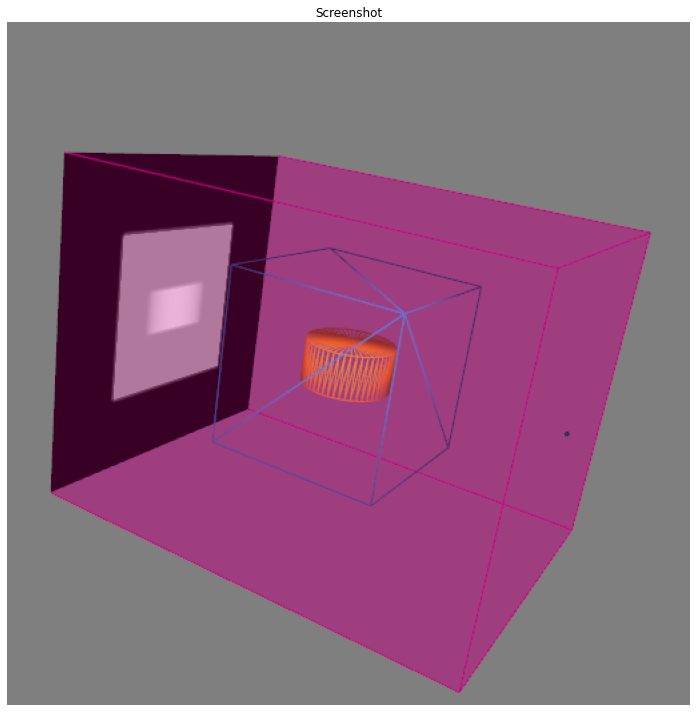

In [10]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-simple_CT.pdf')
plt.savefig('plots/screenshot-beam-off-simple_CT.png')

 Update set of projections while rotating the scene to mimick CT acquisition

In [11]:
%%capture

raw_projections = [];
theta_deg = [];

# Create a GIF file
writer = None
fname_gif = "plots/simpleCT_acquisition.gif"

# if not os.path.exists(fname_gif):
writer = imageio.get_writer(fname_gif, mode='I')

for angle_id in range(0, number_of_projections):

    # Add the rotation angle, starting from 0
    theta_deg.append(-angular_step * angle_id)
    
    # Compute an X-ray image    
    xray_image = np.array(gvxr.computeXRayImage());
    
    # Add to the set of projections
    raw_projections.append(xray_image)
    
    # Update the rendering
    gvxr.displayScene();

    # Take a screenshot
    if writer is not None:
        if not angle_id % 30:
            screenshot = gvxr.takeScreenshot()

            plt.figure(figsize= (10,10))
            plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
            plt.imshow(screenshot)
            plt.axis('off')

            plt.tight_layout()

            plt.savefig('temp.png')            
            plt.close()
            
            
            image = imageio.imread("temp.png")
            writer.append_data(image)

    # Rotate the sample
    gvxr.rotateScene(-angular_step, 0, 0, 1);

# We're done with the writer
if writer is not None:
    writer.close()
    # os.remove(temp.tif)

# Convert to numpy arrays
raw_projections = np.array(raw_projections)

![CT acquisition](./plots/simpleCT_acquisition.gif)

# Perform flat-field correction

In [12]:
# Create a mock dark field image
dark_field_image = np.zeros(raw_projections.shape);

# Create a mock flat field image
flat_field_image = np.ones(raw_projections.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("MeV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
corrected_projections = (raw_projections - dark_field_image) / (flat_field_image - dark_field_image)
# corrected_projections = tomopy.normalize(raw_projections, flat_field_image, dark_field_image)

raw_projections = None # Not needed anymore

## Save the projections using SimpleITK

In [13]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

corrected_projections = np.array(corrected_projections).astype(np.single)

sitk_image = sitk.GetImageFromArray(corrected_projections)
sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
sitk.WriteImage(sitk_image, "gVirtualXRay_output_data/simpleCT_flat.mha", useCompression=True) 

## Calculate $-\log(\mathbf{corrected\_projections}) $ to linearize transmission tomography data

In [14]:
# Create a temporary image to hold the sinogram
minus_log_projs = copy.deepcopy(corrected_projections);
corrected_projections = None # Not needed anymore

# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
minus_log_projs[minus_log_projs < threshold] = threshold;

# Apply the minus log normalisation
minus_log_projs = -np.log(minus_log_projs);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
minus_log_projs /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Make sure the data is in single-precision floating-point numbers
minus_log_projs = np.array(minus_log_projs).astype(np.single)

Reformat the projections into a set of sinograms

In [15]:
sinograms = np.swapaxes(minus_log_projs, 0, 1)
sinograms = np.array(sinograms).astype(np.single)

Save the volume using SimpleITK

In [16]:
sitk_image = sitk.GetImageFromArray(minus_log_projs)
sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
sitk.WriteImage(sitk_image, "gVirtualXRay_output_data/simpleCT_sinograms.mha", useCompression=True)

Plot some sinograms

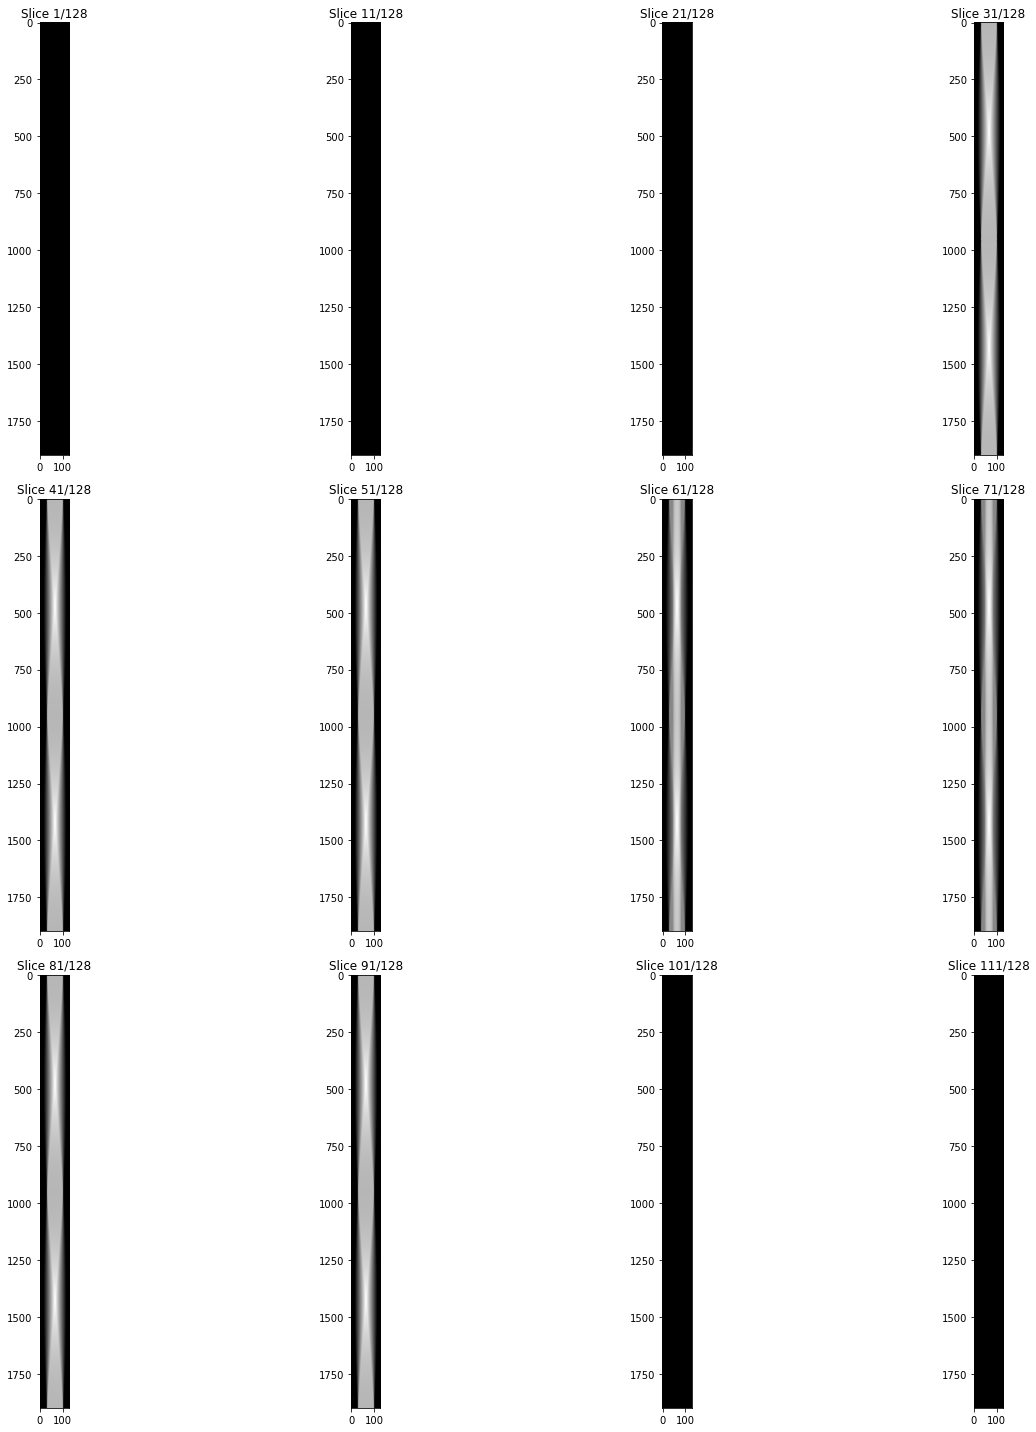

In [17]:
ncols = 4
nrows = 3

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id], cmap='gray')
        
plt.tight_layout()

Find the rotation axis using Tomopy

In [18]:
# rot_center = tomopy.find_center(sinograms, theta, init=290, ind=0, tol=0.5)

Reconstruct the CT slice using Tomopy

In [19]:
# theta_rad = np.array(theta_deg) * math.pi / 180
# rot_centre = minus_log_projs.shape[2] / 2
# # rot_centre = tomopy.find_center(minus_log_projs, theta_rad, init=rot_centre, ind=0, tol=0.01)
# print("Projection sizes:", minus_log_projs.shape)
# print("Rotation centre:", rot_centre)
# CT_volume_in_mu = tomopy.recon(minus_log_projs,
#                          theta_rad,
#                          center=rot_centre,
#                          algorithm='fbp',
#                          sinogram_order=False)

Reconstruct the CT slice using Scikit-Image

In [20]:
CT_volume_in_mu = []

for sinogram in sinograms:
    CT_volume_in_mu.append(iradon(sinogram.T, theta=theta_deg, circle=True))

sinogram = None # Not needed anymore

Save the volume using SimpleITK

In [21]:
CT_volume_in_mu = np.array(CT_volume_in_mu).astype(np.single)

sitk_image = sitk.GetImageFromArray(CT_volume_in_mu)
sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])
sitk.WriteImage(sitk_image, "gVirtualXRay_output_data/simpleCT_volume_in_mu.mha", useCompression=True) 

## Retrieve the linear attenuation coefficients

In [22]:
mu_rho_cube= gvxr.getMassAttenuationCoefficient("Cube",
        json2gvxr.params["Source"]["Beam"][0]["Energy"],
        json2gvxr.params["Source"]["Beam"][0]["Unit"])

mu_rho_cylinder= gvxr.getMassAttenuationCoefficient("Cylinder",
        json2gvxr.params["Source"]["Beam"][0]["Energy"],
        json2gvxr.params["Source"]["Beam"][0]["Unit"])

density_cube = gvxr.getDensity("Cube")
density_cylinder = gvxr.getDensity("Cylinder")

mu_cube = mu_rho_cube * density_cube
mu_cylinder = mu_rho_cylinder * density_cylinder

## Volume rendering of the CT data
**k3d plot not displaying? Ensure notebook plugin is installed with:\
jupyter nbextension install --py --sys-prefix k3d\
jupyter nbextension enable --py --sys-prefix k3d**

In [23]:
plot = k3d.plot()

# loading data to the `density` array
cmap = k3d.colormaps.matplotlib_color_maps.jet

size = np.array(sitk_image.GetSize()) * np.array(sitk_image.GetSpacing())

volume = k3d.volume(
    CT_volume_in_mu.astype(np.float32),
    alpha_coef=5,
    shadow='dynamic',
    samples=300,
    shadow_res=128,
    shadow_delay=50,
    color_range=[0.01, max(mu_cube, mu_cylinder)],
    color_map=(np.array(cmap).reshape(-1,4)).astype(np.float32)
)

volume.transform.bounds = [-size[0] / 2, size[0] / 2,
                           -size[1] / 2, size[1] / 2,
                           -size[2] / 2, size[2] / 2]

plot = k3d.plot(camera_auto_fit=True, height=400)

plot += volume
plot.display()

Output()

Get and save a screenshot

In [24]:
plot.fetch_screenshot()

data = base64.b64decode(plot.screenshot)
with open('plots/simpleCT_volume_rendering.png','wb') as fp:
    fp.write(data)

## Create a binary mask for each structure

In [25]:
cube_mask = np.zeros(CT_volume_in_mu.shape)
cylinder_mask = np.zeros(CT_volume_in_mu.shape)

volume_size_in_px = [cube_mask.shape[2], cube_mask.shape[1], cube_mask.shape[0]]
volume_size_in_cm = [volume_size_in_px[0] * pixel_width * 0.1,
                    volume_size_in_px[1] * pixel_width * 0.1,
                    volume_size_in_px[2] * pixel_height * 0.1]

cube_edge_in_cm = json2gvxr.params["Samples"][0]["Cube"][0] * gvxr.getUnitOfLength(json2gvxr.params["Samples"][0]["Cube"][1]) / gvxr.getUnitOfLength("cm")

cube_edge_in_px = [cube_edge_in_cm / (pixel_width * 0.1),
                   cube_edge_in_cm / (pixel_width * 0.1),
                   cube_edge_in_cm / (pixel_height * 0.1)]

cylinder_height_in_cm = json2gvxr.params["Samples"][1]["Cylinder"][1] * gvxr.getUnitOfLength(json2gvxr.params["Samples"][0]["Cube"][1]) / gvxr.getUnitOfLength("cm")
cylinder_radius_in_cm = json2gvxr.params["Samples"][1]["Cylinder"][2] * gvxr.getUnitOfLength(json2gvxr.params["Samples"][0]["Cube"][1]) / gvxr.getUnitOfLength("cm")

cylinder_height_in_px = cylinder_height_in_cm / (pixel_width * 0.1)
cylinder_radius_in_px = cylinder_radius_in_cm / (pixel_width * 0.1)

cube_offset = [round((volume_size_in_px[0] - cube_edge_in_px[0]) / 2),
         round((volume_size_in_px[1] - cube_edge_in_px[1]) / 2),
         round((volume_size_in_px[2] - cube_edge_in_px[2]) / 2)]

cube_mask[cube_offset[2]:cube_offset[2] + round(cube_edge_in_px[2]),
          cube_offset[1]:cube_offset[1] + round(cube_edge_in_px[1]),
          cube_offset[0]:cube_offset[0] + round(cube_edge_in_px[0])] = np.ones([round(cube_edge_in_px[2]), round(cube_edge_in_px[1]), round(cube_edge_in_px[0])])

offset = round((volume_size_in_px[2] - cylinder_height_in_px) / 2)

rr, cc = disk([round(volume_size_in_px[2] / 2), round(volume_size_in_px[1] / 2)], cylinder_radius_in_px, shape=cylinder_mask[0].shape)

for i in range(offset, offset + round(cylinder_height_in_px)):
    cylinder_mask[i][rr, cc] = 1

# Subtract the cylinder from the cube
cube_mask -= cylinder_mask

# Make sure UINT8 is used
cube_mask = cube_mask.astype(np.uint8)
cylinder_mask = cylinder_mask.astype(np.uint8)

# Convert in SimpleITK images
cube_mask_sitk_image = sitk.GetImageFromArray(cube_mask)
cylinder_mask_sitk_image = sitk.GetImageFromArray(cylinder_mask)

# Erode each mask
filter = sitk.BinaryErodeImageFilter()
filter.SetKernelRadius( 5 )
filter.SetForegroundValue( 1 )
cube_mask_sitk_image = filter.Execute ( cube_mask_sitk_image )
cylinder_mask_sitk_image = filter.Execute ( cylinder_mask_sitk_image )

# Retrieve the numpy arrays
cube_mask = sitk.GetArrayFromImage(cube_mask_sitk_image)
cylinder_mask = sitk.GetArrayFromImage(cylinder_mask_sitk_image)


Save the masks using SimpleITK

In [26]:
sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])
sitk.WriteImage(cube_mask_sitk_image, "gVirtualXRay_output_data/simpleCT_cube_mask.mha", useCompression=True)

sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])
sitk.WriteImage(cylinder_mask_sitk_image, "gVirtualXRay_output_data/simpleCT_cylinder_mask.mha", useCompression=True)

## Compare the linear attenuations from the litterature against those reconstructed by tomography

In [27]:
test = (cube_mask==1)
print("Cube's theoretical linear attenuation coefficient:", mu_cube)
print("Cube's actual linear attenuation coefficient:", np.mean(CT_volume_in_mu[test]))
print("Relative error:", str(100 * (mu_cube - np.mean(CT_volume_in_mu[test])) / mu_cube) + "%")

test = (cylinder_mask==1)
print("Cylinder's theoretical linear attenuation coefficient:", mu_cylinder)
print("Cylinder's actual linear attenuation coefficient:", np.mean(CT_volume_in_mu[test]))
print("Relative error:", str(100 * (mu_cylinder - np.mean(CT_volume_in_mu[test])) / mu_cylinder) + "%") 

Cube's theoretical linear attenuation coefficient: 0.18375873491694744
Cube's actual linear attenuation coefficient: 0.18352048
Relative error: 0.12965583739204178%
Cylinder's theoretical linear attenuation coefficient: 0.3651995075796586
Cylinder's actual linear attenuation coefficient: 0.36398265
Relative error: 0.3332041519795157%


## Display CT slices

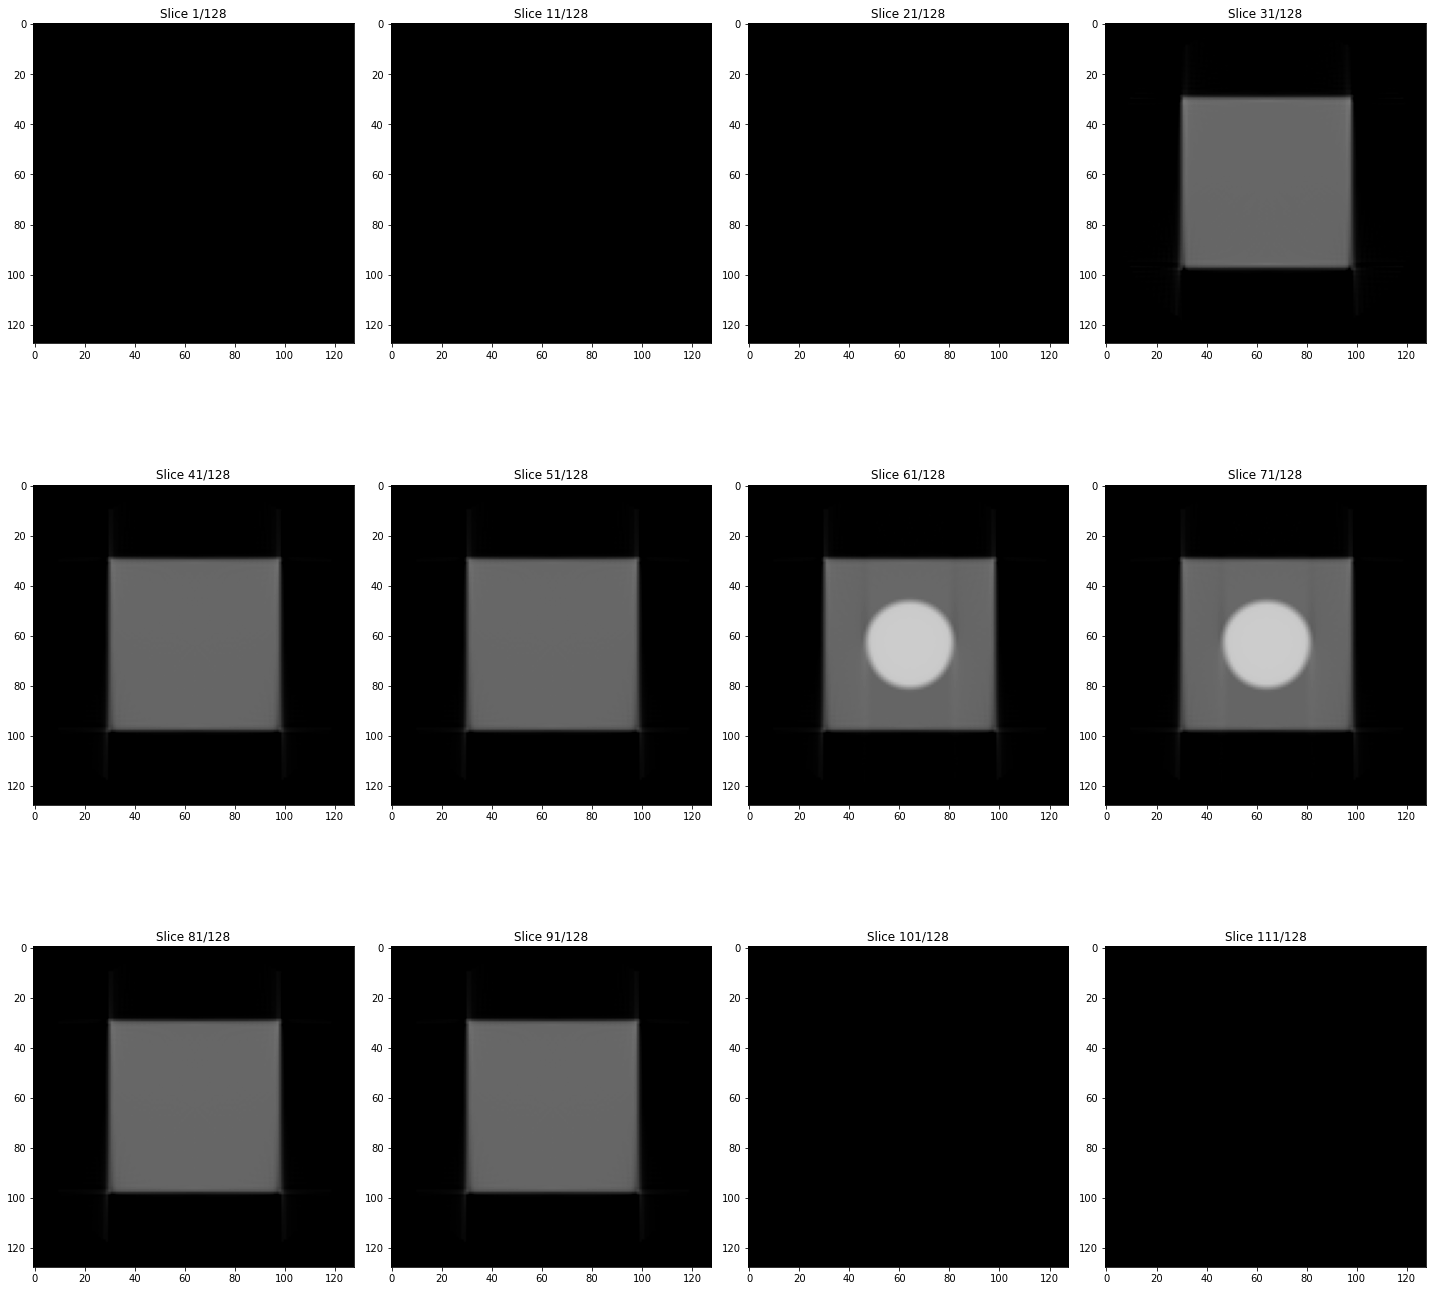

In [28]:
ncols = 4
nrows = 3

step = int(len(CT_volume_in_mu) / (ncols * nrows))
slices = range(0, int(len(CT_volume_in_mu)), step)

fig = plt.figure(figsize= (20,20))

min_val = 0
max_val = 0.5
for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(len(CT_volume_in_mu)))
        ax.imshow(CT_volume_in_mu[slice_id], cmap='gray', vmin=0, vmax=1.25 * max(mu_cube, mu_cylinder))
        
plt.tight_layout()

In [29]:
CT_volume = None # Not needed anymore
gvxr.destroyAllWindows();